<a href="https://colab.research.google.com/github/alonh1/ember-3.9/blob/master/Advanced_ML_EX1_315682773_322155516_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install yellowbrick

In [2]:
%pip install -U scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=f34266bbca15911323658f5e08342954900e943a0a6a419ad1643566069d7f67
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [3]:
%pip install threadpoolctl


In [4]:
%pip install --upgrade threadpoolctl


In [5]:
%pip install umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=e4f123fee3865d7bb32f566833756162c7ec74a1a2f2dff56607405b1260c4f8
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [6]:
import sys
import pandas as pd

In [7]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Part 0: Loading the data

In [8]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [9]:
import numpy as np
import time
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pickle
import skfuzzy as fuzz
import umap.umap_ as umap
import warnings; warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="spectral initialisation failed")

In [10]:
# Data transformation definition
transform = transforms.Compose([transforms.ToTensor()])
# MNIST dataset download
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Data loaders creation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 93524190.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58975508.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31683432.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 798697.33it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Exploring the data


Total training samples: 60000
Total testing samples: 10000
Unique classes count: 10
First image shape: torch.Size([1, 28, 28])
Classes in the dataset: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


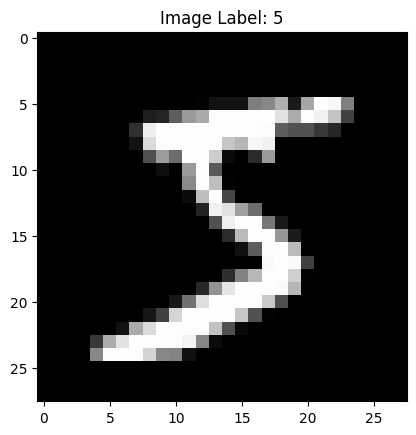

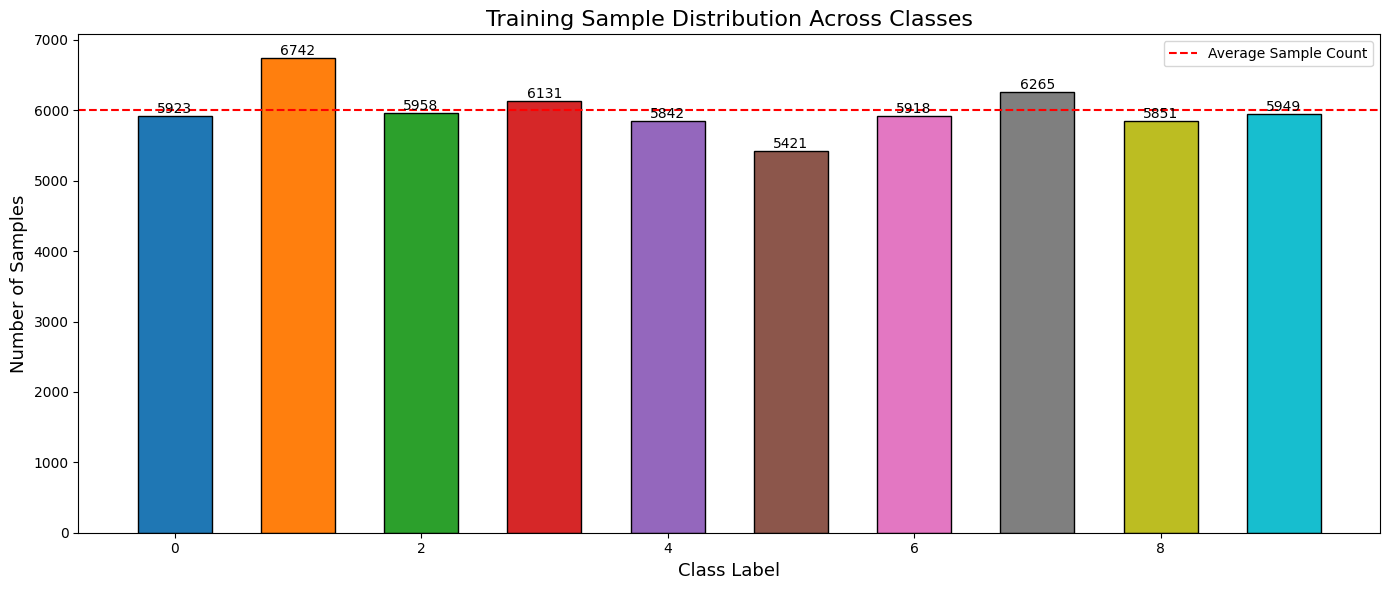

Observation: Training samples distribution visualized with enhanced features.


In [11]:
# Acquiring basic information about the dataset
dataset_classes = trainset.classes
total_classes = len(dataset_classes)
train_size = len(trainset)
test_size = len(testset)

# Printing dataset details
print(f'Total training samples: {train_size}')
print(f'Total testing samples: {test_size}')
print(f'Unique classes count: {total_classes}')
first_image_shape = trainset[0][0].shape
print(f'First image shape: {first_image_shape}')
print(f'Classes in the dataset: {dataset_classes}')

# Retrieving and displaying the first image from the dataset
first_image, associated_label = trainset[0]
converted_image = first_image.numpy().squeeze()

# Visualizing the image
plt.imshow(converted_image, cmap='gray')
plt.title(f'Image Label: {associated_label}')
plt.show()

# Analyzing the distribution of samples across different labels
sample_count_per_label = []
for current_label in dataset_classes:
    relevant_indices = [i for i, lbl in enumerate(trainset.targets) if lbl == current_label]
    sample_count_per_label.append(len(trainset.data[relevant_indices]))

# Enhanced bar chart for visualizing sample distribution
plt.figure(figsize=(14, 6))
train_labels = [label for _, label in trainset]
unique_labels, sample_counts = np.unique(train_labels, return_counts=True)
color_scheme = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2",
                "#7f7f7f", "#bcbd22", "#17becf"]  # Custom color palette

# Creating a bar chart with horizontal lines and altered bar widths
bar_width = 0.6
plt.bar(unique_labels, sample_counts, color=color_scheme, width=bar_width, edgecolor='black')
plt.axhline(y=np.mean(sample_counts), color='r', linestyle='--', label='Average Sample Count')
plt.xlabel('Class Label', fontsize="13")
plt.ylabel('Number of Samples', fontsize="13")
plt.title('Training Sample Distribution Across Classes', fontsize="16")
plt.legend()

# Adding value labels on top of each bar
for i, count in enumerate(sample_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print('Observation: Training samples distribution visualized with enhanced features.')


# Part 1: Dimensionality Reduction


### setting up the evnironment

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# Dataset and run configuration
mnist = load_digits()
IS_SLOW_RUN = False

# Classifier selection based on run configuration
CLF_TO_TEST = ['mlp', 'svm'] if IS_SLOW_RUN else ['svm']

def _reduce_dim(dim_reducer, X_train, X_test):
    """Dimensionality reduction."""
    dim_reducer.fit(X_train)
    return dim_reducer.transform(X_train), dim_reducer.transform(X_test)

def _train_and_evaluate_results(dim_reducer, X_train_new_space, X_test_new_space, y_train, y_test, clf_type='mlp'):
    """Train and evaluate classifier."""
    assert clf_type in CLF_TO_TEST
    clf = MLPClassifier(solver='lbfgs') if clf_type == 'mlp' else svm.SVC(kernel='rbf', gamma='scale')
    clf.fit(X_train_new_space, y_train)
    return clf.score(X_test_new_space, y_test)

def _visualize_features(X_test_new_space, y_test):
    """Visualization of features."""
    num_features = min(6, X_test_new_space.shape[1])
    fig, axes = plt.subplots(1, num_features // 2, figsize=(16, 5))
    fig.suptitle('Feature Space Visualization')
    for i in range(num_features // 2):
        ax = axes[i]
        ax.scatter(X_test_new_space[:, 2*i], X_test_new_space[:, 2*i + 1], c=y_test, cmap='jet')
        ax.set_xlabel(f'Feature {2*i}')
        ax.set_ylabel(f'Feature {2*i + 1}')
    plt.show()

def _run_tsne(tsne_clf, X_train, y_train, X_test, y_test, clf_type='mlp', n_neighbors=2, sampling_test=None):
    """Run TSNE analysis and classifier training."""
    start_time = datetime.utcnow()
    X_train_tsne = tsne_clf.fit_transform(X_train)
    X_test_subset = X_test[:sampling_test] if sampling_test else X_test

    neighbor_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X_train)
    distances, indices = neighbor_model.kneighbors(X_test_subset)
    weights = distances / distances.sum(axis=1)[:, np.newaxis]
    X_test_tsne = np.dot(weights, X_train_tsne[indices])

    clf = MLPClassifier(solver='lbfgs') if clf_type == 'mlp' else svm.SVC(kernel='rbf', gamma='scale')
    clf.fit(X_train, y_train)
    score = clf.score(X_test_subset, y_test[:len(X_test_subset)])
    duration = (datetime.utcnow() - start_time).total_seconds()

    return score, duration

# Place to store results
all_results = []
df = pd.DataFrame([])


In [13]:
X_train = trainset.data.reshape(-1, 784)
X_test = testset.data.reshape(-1, 784)
y_train = trainset.targets.numpy()
y_test = testset.targets.numpy()

Trying PCA

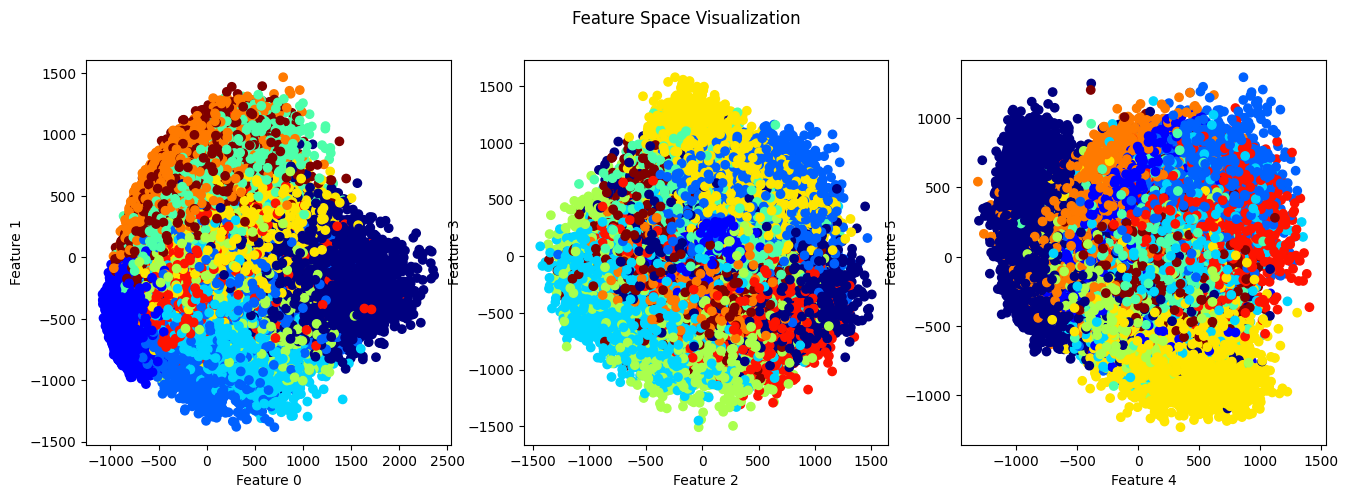

In [14]:
from datetime import datetime
from sklearn.decomposition import PCA
import pandas as pd

# Determine the number of components
full_n_components = X_train.shape[1]
n_components = X_test.shape[1]

# Initialize PCA and reduce dimensions of train and test sets
initial_pca = PCA(n_components=n_components)
X_train_new_space, X_test_new_space = _reduce_dim(initial_pca, X_train, X_test)

# Visualize the features of the transformed train set
_visualize_features(X_train_new_space, y_train)

# Set of components to iterate over, depending on run configuration
components_range = range(60, 4, -6) if IS_SLOW_RUN else [22]

# Iterate over classifiers and different numbers of components
for clf_type in CLF_TO_TEST:
    for comp in components_range:
        pca_start_time = datetime.utcnow()

        # Apply PCA with current number of components
        pca = PCA(n_components=comp)
        transformed_X_train, transformed_X_test = _reduce_dim(pca, X_train, X_test)

        # Measure the time taken for dimensionality reduction
        pca_duration = (datetime.utcnow() - pca_start_time).total_seconds()

        # Train and evaluate the model
        model_score = _train_and_evaluate_results(pca, transformed_X_train, transformed_X_test, y_train, y_test, clf_type=clf_type)

        # Record results in a dataframe
        # df = df.append([{'alg': str(pca), 'n_components': comp, 'test_score': model_score,
        #                  'duration': pca_duration, 'clf_type': clf_type}])
        # use concat instead of append
        df = pd.concat([df, pd.DataFrame([{'alg': str(pca), 'n_components': comp, 'test_score': model_score,
                         'duration': pca_duration, 'clf_type': clf_type}])])


Exploring tunbale params

In [15]:
from datetime import datetime
from sklearn.decomposition import PCA
import pandas as pd

# Other initializations and dataset preparations

# Range of parameters to test
n_components_range = range(60, 4, -6) if IS_SLOW_RUN else [22]
whiten_options = [True, False]
svd_solver_options = ['auto', 'full', 'arpack', 'randomized']
iterated_power_options = [2, 3, 5, 7] # Only effective with svd_solver='randomized'

# Iterate over classifiers, PCA parameters, and different numbers of components
for clf_type in CLF_TO_TEST:
    for n_comp in n_components_range:
        for whiten in whiten_options:
            for svd_solver in svd_solver_options:
                for iter_power in iterated_power_options:
                    # Apply PCA with current settings
                    pca = PCA(n_components=n_comp, whiten=whiten, svd_solver=svd_solver,
                              iterated_power=iter_power if svd_solver == 'randomized' else 'auto')

                    pca_start_time = datetime.utcnow()
                    transformed_X_train, transformed_X_test = _reduce_dim(pca, X_train, X_test)
                    pca_duration = (datetime.utcnow() - pca_start_time).total_seconds()

                    # Train and evaluate the model
                    model_score = _train_and_evaluate_results(pca, transformed_X_train, transformed_X_test, y_train, y_test, clf_type=clf_type)

                    # Record results in a dataframe
                    # df = df.append([{'alg': str(pca), 'n_components': n_comp, 'whiten': whiten, 'svd_solver': svd_solver,
                    #                  'iterated_power': iter_power, 'test_score': model_score, 'duration': pca_duration, 'clf_type': clf_type}])
                    # use concat instead of append
                    df = pd.concat([df, pd.DataFrame([{'alg': str(pca), 'n_components': n_comp, 'whiten': whiten, 'svd_solver': svd_solver,
                                     'iterated_power': iter_power, 'test_score': model_score, 'duration': pca_duration, 'clf_type': clf_type}])])


Trying t-SNE

In [ ]:
import tqdm

# Define perplexity values to run based on the run configuration
perplexity_values = [2, 5, 30, 50, 100] if IS_SLOW_RUN else [30]

# Iterate over each classifier type in CLF_TO_TEST
for clf_type in CLF_TO_TEST:
    # Iterate over each perplexity value
    for perplexity in tqdm.tqdm(perplexity_values):
        # Initialize t-SNE with the current perplexity and other fixed parameters
        tsne_params = {
            'n_components': 2,
            'perplexity': perplexity,
            'method': 'barnes_hut',
            'random_state': 42
        }
        tsne_clf = TSNE(**tsne_params)

        # Run t-SNE and evaluate performance
        score, duration = _run_tsne(tsne_clf, X_train, y_train, X_test, y_test, clf_type=clf_type, n_neighbors=2, sampling_test=None)

        # Record the results in a dataframe
        result_record = {
            'alg': str(tsne_clf),
            'n_components': tsne_params['n_components'],
            'test_score': score,
            'duration': duration,
            'params': str(tsne_params),
            'clf_type': clf_type,
            'n_neighbors': 2,
            'sampling_test': None
        }
        # df = df.append([result_record])
        # use concat instead of append
        df = pd.concat([df, pd.DataFrame([result_record])])

# Optionally, save results to a CSV file
df.to_csv('all_results.csv')


100%|██████████| 1/1 [13:42<00:00, 822.28s/it]


trying UMAP

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


visualizing features of UMAP(n_neighbors=2, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


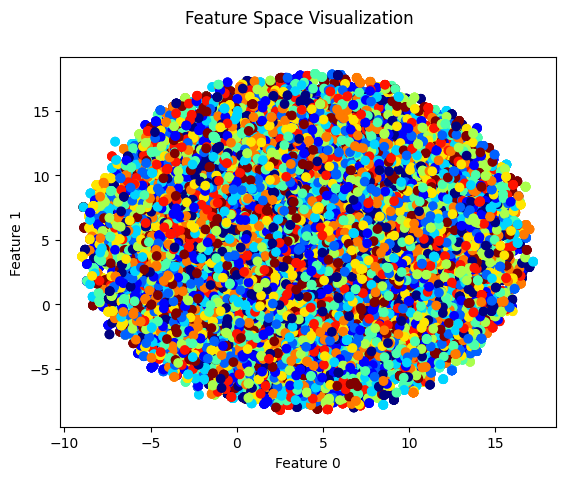

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


visualizing features of UMAP(n_neighbors=5, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


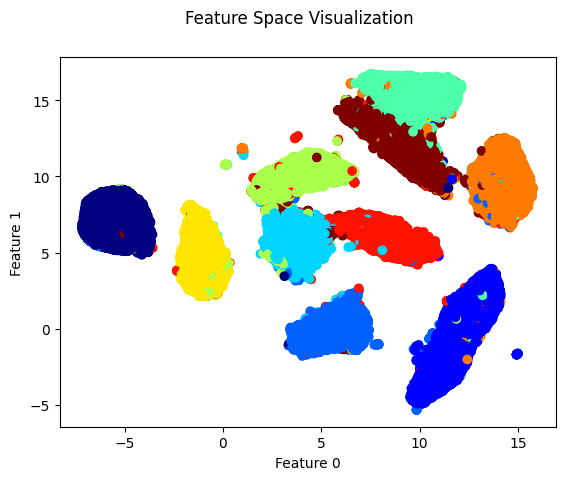

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


visualizing features of UMAP(n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


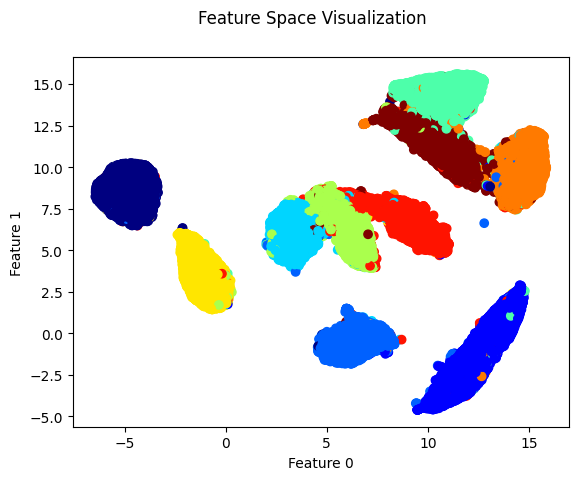

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


visualizing features of UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


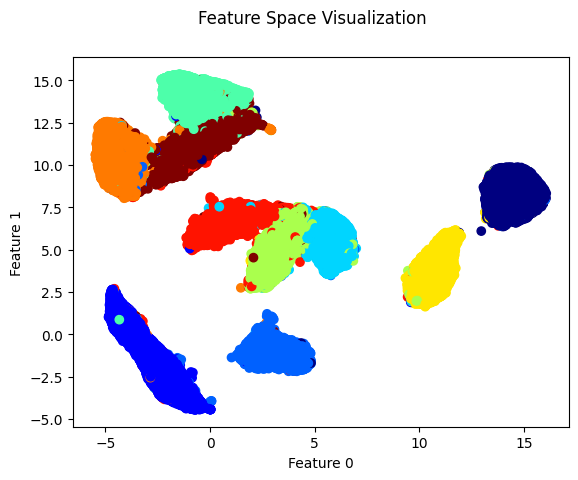

In [23]:
n_neighbors_to_run = [2, 5, 10, 15]

for clf_type in CLF_TO_TEST:
    for n_neighbors in n_neighbors_to_run:
        start_time = datetime.utcnow()
        umap_transformer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
        X_train_new_space, X_test_new_space = _reduce_dim(umap_transformer, X_train, X_test)

        print(f'visualizing features of {str(umap_transformer)}')
        _visualize_features(X_train_new_space, y_train)

        score = _train_and_evaluate_results(umap_transformer, X_train_new_space,
                                            X_test_new_space, y_train, y_test, clf_type=clf_type)

        duration = (datetime.utcnow() - start_time).total_seconds()

        df = df.append([{'alg': str(umap_transformer), 'test_score': score,
                               'duration': duration, 'clf_type': clf_type, 'n_neighbors': n_neighbors}])

#         df.to_csv('all_results.csv')

data for later report

In [38]:
import pandas as pd

def _get_alg(x):
    if not isinstance(x, str):
        return ''

    if 'UMAP' in x:
        return 'UMAP'
    if 'PCA' in x:
        return 'PCA'
    assert False



# Check for duplicate column names
if df.columns.duplicated().any():
    print("Duplicate column names found. Here are the duplicates:", df.columns[df.columns.duplicated()])


if 'alg' in df.columns:

    df.rename(columns={'alg': 'algorithm_obj'}, inplace=True)
else:
    print("'alg' column not found. Ensure the correct column is being renamed.")

df['algorithm'] = df['algorithm_obj'].apply(_get_alg)



Duplicate column names found. Here are the duplicates: Index(['algorithm_obj'], dtype='object')
'alg' column not found. Ensure the correct column is being renamed.


ValueError: cannot reindex on an axis with duplicate labels

In [39]:
df[(df['clf_type'] == 'svm')].groupby(['algorithm'], dropna=False).test_score.describe()

,count,mean,std,min,25%,50%,75%,max
algorithm,,,,,,,,
PCA,33.0,0.977800,0.000566,0.9770,0.977300,0.97750,0.978300,0.9787
UMAP,1.0,0.953100,NaN,0.9531,0.953100,0.95310,0.953100,0.9531
NaN,8.0,0.730075,0.376023,0.1218,0.704975,0.92265,0.947775,0.9531


# Part 2: Clustering the raw data

## (5)

## a.

In [ ]:

# Reshape the training images to 1D arrays
X_train = trainset.data.reshape(-1, 784)
X_test = testset.data.reshape(-1, 784)
y_train = trainset.targets.numpy()
y_test = testset.targets.numpy()

num_classes = len(np.unique(y_train))

# Initialize KMeans model and fit on training set
kmeans = KMeans(n_clusters=num_classes, init="random", n_init='auto', random_state=42)
kmeans.fit(X_train)

# Initialize KMeans++ model and fit on training set
kmeans_pp = KMeans(n_clusters=num_classes, init='k-means++', n_init='auto', random_state=42)
kmeans_pp.fit(X_train)

# Initialize KMeans model and fit on training set
m = 2   # Fuzziness parameter
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_train.T, num_classes, m, error=0.005, maxiter=1000, init=None)

In [ ]:
# Code for evaluating KMeans clustering results with standard metrics

# Obtain predicted clusters from KMeans on the training data
cluster_predictions = kmeans.predict(X_train)

# Define a dictionary to store the evaluation metrics
evaluation_metrics = {
    'Silhouette Coefficient': silhouette_score(X_train, cluster_predictions),
    'Homogeneity Score': homogeneity_score(y_train, cluster_predictions),
    'Completeness Score': completeness_score(y_train, cluster_predictions)
}

# Print out the evaluation metrics
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value:.4f}")


Silhouette Coefficient: 0.0585
Homogeneity Score: 0.4936
Completeness Score: 0.5009


In [ ]:
# evaluate KMeans++ clustering results with standard metrics

# Obtain predicted clusters from KMeans on the training data
cluster_predictions = kmeans_pp.predict(X_train)

# Define a dictionary to store the evaluation metrics
evaluation_metrics = {
    'Silhouette Coefficient': silhouette_score(X_train, cluster_predictions),
    'Homogeneity Score': homogeneity_score(y_train, cluster_predictions),
    'Completeness Score': completeness_score(y_train, cluster_predictions)
}

# Print out the evaluation metrics
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value:.4f}")

Silhouette Coefficient: 0.0559
Homogeneity Score: 0.4804
Completeness Score: 0.4832


## b.

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, method='barnes_hut', random_state=42)
X_train_tsne = tsne.fit_transform(X_train)



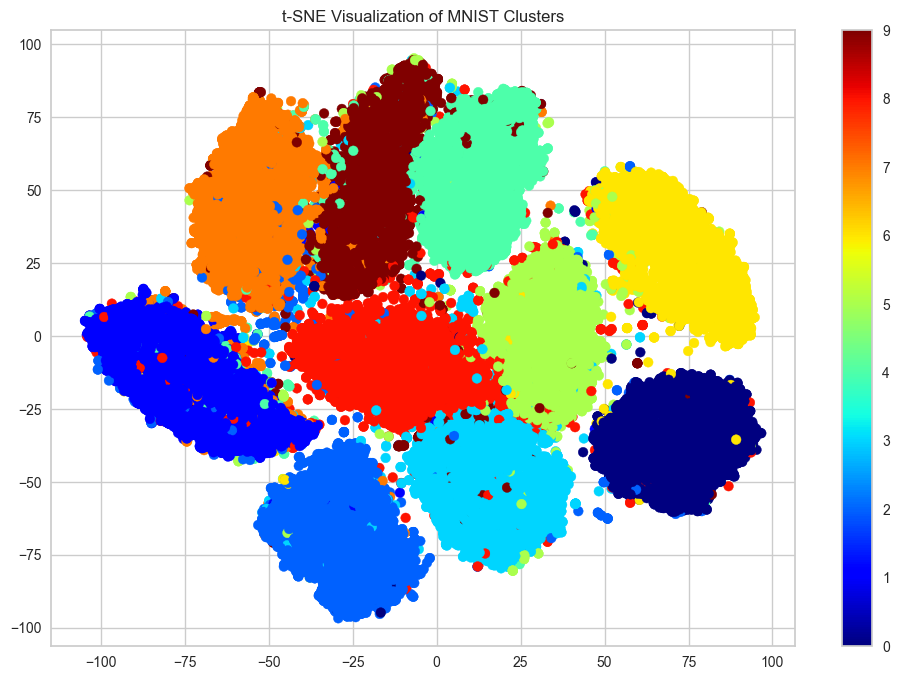

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='jet')
plt.title('t-SNE Visualization of MNIST Clusters')
plt.colorbar()
plt.show()

### c.

In [ ]:
# Initialize KMeans model and fit on training set
kmeans = KMeans(n_clusters=num_classes, init="random", n_init='auto', random_state=42)
kmeans.fit(X_train_tsne)

# Initialize KMeans++ model and fit on training set
kmeans_pp = KMeans(n_clusters=num_classes, init='k-means++', n_init='auto', random_state=42)
kmeans_pp.fit(X_train_tsne)

KMeans(n_clusters=10, n_init='auto', random_state=42)

In [ ]:
# Evaluate the clustering result using standard evaluation metrics. You may use the digit labels as external data for evaluation.
cluster_predictions = kmeans.predict(X_train_tsne)
evaluation_metrics = {
    'Silhouette Coefficient': silhouette_score(X_train_tsne, cluster_predictions),
    'Homogeneity Score': homogeneity_score(y_train, cluster_predictions),
    'Completeness Score': completeness_score(y_train, cluster_predictions)
}

print('KMeans Clustering Results for MNIST Dataset with Dimensionality Reduction for 10 Clusters')
# Print out the evaluation metrics
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value:.4f}")

KMeans Clustering Results for MNIST Dataset with Dimensionality Reduction for 10 Clusters
Silhouette Coefficient: 0.4557
Homogeneity Score: 0.8240
Completeness Score: 0.8242


In [ ]:
# evaluate KMeans++ clustering results with standard metrics

# Obtain predicted clusters from KMeans on the training data
cluster_predictions = kmeans_pp.predict(X_train_tsne)

# Define a dictionary to store the evaluation metrics
evaluation_metrics = {
    'Silhouette Coefficient': silhouette_score(X_train_tsne, cluster_predictions),
    'Homogeneity Score': homogeneity_score(y_train, cluster_predictions),
    'Completeness Score': completeness_score(y_train, cluster_predictions)
}

# Print out the evaluation metrics
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value:.4f}")


Silhouette Coefficient: 0.4551
Homogeneity Score: 0.8259
Completeness Score: 0.8262


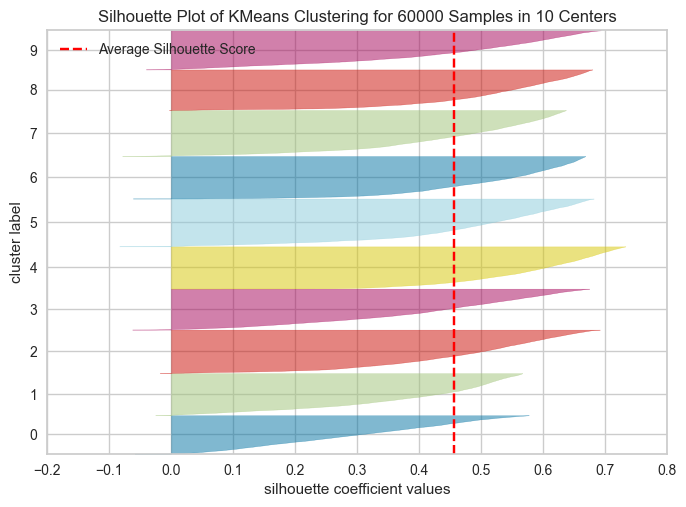

<Figure size 800x550 with 0 Axes>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

# Visualization of the silhouette scores for KMeans clustering with 10 clusters with dimensionality reduction
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_train_tsne)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure
plt.savefig('silhouette.jpeg')  # Save the plot as an image
plt.show()

### d.

In [ ]:
from tqdm import tqdm

# Explore the tunable parameters of the algorithm and their effect on the clustering results.
# Let's try to find the optimal number of clusters for KMeans and perplexity for t-SNE using the elbow method and the silhouette score.
minimal_clusters = len(np.unique(y_train))
# start from min and explore 10 more values by range of 2
num_of_clusters = range(minimal_clusters, minimal_clusters + 10, 2)
perplexity_values = [5, 30, 50]
clustering_algorithms = ['kmeans', 'kmeans_pp']

# create a dict to store the results
results = {}
# populate the dict with num_of_clusters and perplexity_values, algorithm as keys and score type as key
for n_clusters in num_of_clusters:
    for perplexity in perplexity_values:
        for algorithm in clustering_algorithms:
            results[(n_clusters, perplexity, algorithm)] = {'silhouette': 0, 'homogeneity': 0, 'completeness': 0}

# iterate over the number of clusters and perplexity values
for n_clusters in tqdm(num_of_clusters):
    for perplexity in perplexity_values:
        for clustering_algorithm in clustering_algorithms:
        # initialize the TSNE model with current perplexity
            tsne = TSNE(n_components=2, perplexity=perplexity, method='barnes_hut', random_state=42)
            X_train_tsne = tsne.fit_transform(X_train)

            if clustering_algorithm == 'kmeans':
                # initialize the KMeans model with current number of clusters
                kmeans = KMeans(n_clusters=n_clusters, init="random", n_init='auto', random_state=42)
                kmeans.fit(X_train_tsne)

                # obtain the silhouette score for the current number of clusters
                cluster_predictions = kmeans.predict(X_train_tsne)
                silhouette = silhouette_score(X_train_tsne, cluster_predictions)
                homogeneity = homogeneity_score(y_train, cluster_predictions)
                completeness = completeness_score(y_train, cluster_predictions)

                # store the results in the dict
                results[(n_clusters, perplexity, clustering_algorithm)] = {'silhouette': silhouette, 'homogeneity': homogeneity, 'completeness': completeness}

            else:
                # initialize the KMeans++ model with current number of clusters
                kmeans_pp = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', random_state=42)
                kmeans_pp.fit(X_train_tsne)

                # obtain the silhouette score for the current number of clusters
                cluster_predictions = kmeans_pp.predict(X_train_tsne)
                silhouette = silhouette_score(X_train_tsne, cluster_predictions)
                homogeneity = homogeneity_score(y_train, cluster_predictions)
                completeness = completeness_score(y_train, cluster_predictions)

                # store the results in the dict
                results[(n_clusters, perplexity, clustering_algorithm)] = {'silhouette': silhouette, 'homogeneity': homogeneity, 'completeness': completeness}


print(results)

# create a dataframe from the results dict
df = pd.DataFrame.from_dict(results, orient='index')
# save df as csv file clustering_results.csv
df.to_csv('clustering_results.csv')


100%|██████████| 5/5 [1:59:13<00:00, 1430.62s/it]

{(10, 5, 'kmeans'): {'silhouette': 0.34753633, 'homogeneity': 0.6829247192471454, 'completeness': 0.6844700243842708}, (10, 5, 'kmeans_pp'): {'silhouette': 0.3470747, 'homogeneity': 0.6819675435136345, 'completeness': 0.683780180332384}, (10, 30, 'kmeans'): {'silhouette': 0.42425662, 'homogeneity': 0.7999028708240039, 'completeness': 0.8032879386096796}, (10, 30, 'kmeans_pp'): {'silhouette': 0.42074543, 'homogeneity': 0.7799722377182736, 'completeness': 0.7876410472416451}, (10, 50, 'kmeans'): {'silhouette': 0.4557361, 'homogeneity': 0.8239765597778728, 'completeness': 0.8242181416957495}, (10, 50, 'kmeans_pp'): {'silhouette': 0.45514053, 'homogeneity': 0.8259124798739066, 'completeness': 0.8261670779279577}, (12, 5, 'kmeans'): {'silhouette': 0.35226712, 'homogeneity': 0.7508224155604839, 'completeness': 0.6972588620955028}, (12, 5, 'kmeans_pp'): {'silhouette': 0.34686038, 'homogeneity': 0.7347760408942129, 'completeness': 0.6829718264196608}, (12, 30, 'kmeans'): {'silhouette': 0.41942

In [ ]:
print(df)

                 silhouette  homogeneity  completeness
10 5  kmeans       0.347536     0.682925      0.684470
      kmeans_pp    0.347075     0.681968      0.683780
   30 kmeans       0.424257     0.799903      0.803288
      kmeans_pp    0.420745     0.779972      0.787641
   50 kmeans       0.455736     0.823977      0.824218
      kmeans_pp    0.455141     0.825912      0.826167
12 5  kmeans       0.352267     0.750822      0.697259
      kmeans_pp    0.346860     0.734776      0.682972
   30 kmeans       0.419424     0.835237      0.778143
      kmeans_pp    0.413618     0.810169      0.754806
   50 kmeans       0.436420     0.846749      0.790120
      kmeans_pp    0.442760     0.824834      0.769628
14 5  kmeans       0.345745     0.726986      0.635513
      kmeans_pp    0.343911     0.729302      0.637956
   30 kmeans       0.411253     0.830325      0.730333
      kmeans_pp    0.410462     0.835764      0.735703
   50 kmeans       0.442955     0.864011      0.762424
      kmea

## 6. We'll chose t-SNE with 10 classes with perplexity=50 on regular KNN.

# Part 3:

## 7 a, b.

In [ ]:
# Reshape the training images to 1D arrays
X_train = trainset.data.reshape(-1, 784)
X_test = testset.data.reshape(-1, 784)
y_train = trainset.targets.numpy()
y_test = testset.targets.numpy()


In [ ]:
# import svm
from sklearn import svm
from tqdm import tqdm
# create results per kernel
kernels_types = ['linear', 'rbf', 'poly', 'sigmoid']
results = {}
for kernel in tqdm(kernels_types):
    # if linear kernel use LinearSVC
    if kernel == 'linear':
        clf = svm.LinearSVC(random_state=42)
    else:
        clf = svm.SVC(kernel=kernel, gamma='scale', random_state=42, decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    results[kernel] = score

# store the results in a dataframe
df = pd.DataFrame.from_dict(results, orient='index')
# save the dataframe as csv file clf_results_full_dim.csv
df.to_csv('clf_results_full_dim.csv')

print(df)

100%|██████████| 4/4 [14:16<00:00, 214.08s/it]

              0
linear   0.8236
rbf      0.9792
poly     0.9771
sigmoid  0.7759


## 8. a,b

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, method='barnes_hut', random_state=42)

# Fit and transform the training data to 2D
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)



In [ ]:
# Explore different parameters for the classification model and evaluate the performance of the classifiers.
results = {}
for kernel in tqdm(kernels_types):
    if kernel == 'linear':
        clf = svm.LinearSVC(random_state=42)
    else:
        clf = svm.SVC(kernel=kernel, gamma='scale', random_state=42, decision_function_shape='ovo')
    clf.fit(X_train_tsne, y_train)
    score = clf.score(X_test_tsne, y_test)
    results[kernel] = score

# store the results in a dataframe
df = pd.DataFrame.from_dict(results, orient='index')
# save the dataframe as csv file clf_results_full_dim.csv
df.to_csv('clf_results_reduced_dim.csv')

print(df)

100%|██████████| 4/4 [01:11<00:00, 17.86s/it]

              0
linear   0.0891
rbf      0.1074
poly     0.1204
sigmoid  0.2150


In [ ]:
# it seems that for the reduced dimensionality the svm classifier isn't working well.
# let's try to use the MLPClassifier instead
from sklearn.neural_network import MLPClassifier

# create results per kernel
clf = MLPClassifier(random_state=42)
clf.fit(X_train_tsne, y_train)
score = clf.score(X_test_tsne, y_test)
results['MLPClassifier'] = score

# store the results in a dataframe
df = pd.DataFrame.from_dict(results, orient='index')
# save the dataframe as csv file clf_results_full_dim.csv
df.to_csv('clf_results_reduced_dim.csv')

print(df)

                    0
linear         0.0891
rbf            0.1074
poly           0.1204
sigmoid        0.2150
MLPClassifier  0.1161


### Explanation:

 t-SNE is not used as a dimensionality reduction technique for classification because it does not learn a function from the original space to the new (lower) dimensional one. As such, when we try to use our classifier on new or unseen data, we will not be able to map or pre-process these new data according to the previous t-SNE results.

In [ ]:
# let's use umap instead of tsne
reducer = umap.UMAP(n_components=5, n_neighbors=5)
X_train_umap = reducer.fit_transform(X_train)
X_test_umap = reducer.fit_transform(X_test)

# Explore different parameters for the classification model and evaluate the performance of the classifiers.
results = {}
for kernel in tqdm(kernels_types):
    if kernel == 'linear':
        clf = svm.LinearSVC(random_state=42)
    else:
        clf = svm.SVC(kernel=kernel, gamma='scale', random_state=42, decision_function_shape='ovo')
    clf.fit(X_train_umap, y_train)
    score = clf.score(X_test_umap, y_test)
    results[kernel] = score

    # add the mlp classifier
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train_umap, y_train)
    score = clf.score(X_test_umap, y_test)
    results['MLPClassifier'] = score

# store the results in a dataframe
df = pd.DataFrame.from_dict(results, orient='index')
# save the dataframe as csv file clf_umap_results.csv
df.to_csv('clf_umap_results.csv')
print(df)

100%|██████████| 4/4 [04:04<00:00, 61.11s/it]

                    0
linear         0.0759
MLPClassifier  0.0085
rbf            0.0653
poly           0.0319
sigmoid        0.0443


                    0
linear         0.1325
MLPClassifier  0.1812
rbf            0.1446
poly           0.1126
sigmoid        0.0034


In [ ]:
# Visualizing the clusters by displaying a few images from each cluster

num_images_per_cluster = 4

for cluster_idx in range(num_classes):
    # Select the indices of the training samples in the current cluster
    cluster_indices = np.where(predicted_clusters == cluster_idx)[0]

    # Select a random subset of the images in the current cluster
    random_indices = np.random.choice(cluster_indices, size=num_images_per_cluster, replace=False)

    # Create a figure to display the images in the current cluster
    fig, axs = plt.subplots(1, num_images_per_cluster, figsize=(10, 3))
    fig.suptitle(f'Cluster {cluster_idx}')

    # Loop over the selected images
    for i, idx in enumerate(random_indices):
        img, label = trainset[idx]
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f'Label: {label}')
    plt.show()

In [ ]:
#############################################################################
##    Explore parameters and evaluate their effect on the results          ##
#############################################################################

print("We chose to focus on determining the number of clusters.")
print("Around ~60 clusters seems to be a good choice.")
print("The explanation for more clusters than possible digits is because of more than one way of sketching a digit.\nFor example 7 with or without a cross line.")

n_clusters = [2**i for i in range(3,8)]
acc =[]
for k in n_clusters:
    kmeans_pp = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans_pp.fit(X_train)
    kmeans_pp_reference_labels = retrieve_info(kmeans_pp.labels_, y_train)
    kmeans_pp_train_pred = predict_labels(kmeans_pp, kmeans_pp_reference_labels, X_train)
    acc.append(calc_accuracy(kmeans_pp_train_pred, y_train))

plt.figure(figsize=(16,8))
plt.plot(n_clusters, acc)
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy on train set')
plt.title('Elbow Method showing the optimal cluster number')
plt.show()

In [ ]:
kmeans_pp = KMeans(n_clusters=64, init='k-means++', n_init='auto', random_state=42)
kmeans_pp.fit(X_train)
kmeans_pp_reference_labels = retrieve_info(kmeans_pp.labels_, y_train)
kmeans_pp_test_pred = predict_labels(kmeans_pp, kmeans_pp_reference_labels, X_test)

print("*** K-means++ metrics ***")
calc_metrics(kmeans_pp,y_train)
print(f"Testset accuracy: {calc_accuracy(kmeans_pp_test_pred, y_test):.4f}")